In [1]:
import pandas as pd
import numpy as np

import keras

from keras import Sequential

from keras.layers import LSTM, Activation, Dropout, Dense, Input,  Bidirectional, BatchNormalization, Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, schedules

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [40]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag
import os, re, csv, math, codecs, string
from sklearn import model_selection
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import spacy
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI

In [ ]:
movie_df=pd.read_csv('../input/imdb-movie-ratings-sentiment-analysis/movie.csv')
movie_df.head()

In [ ]:
# !pip install googletrans==3.1.0a0

# from googletrans import Translator

# # Initialize the translator
# translator = Translator()

In [73]:
def translate_text(text):
    try:
        translation = translator.translate(text, src='en', dest='hi')
        return translation.text if translation is not None else None
    except Exception as e:
        print(f"Error translating text: {e}")
        return None


In [ ]:
# Apply the translation function to the 'Hindi_text' column with tqdm
#tqdm.pandas(desc="Translating English to Hindi", unit="rows")
#movie_df['hindi_text'] = movie_df['text'].progress_apply(translate_text)

# movie_df.to_csv('eng-hindi_imdb.csv',index=False)

In [4]:
df = pd.read_csv('../input/eng-hindi-imdb-movie-ratings/eng-hindi_imdb.csv')
df.head()

,text,label,hindi_text
0,I grew up (b. 1965) watching and loving the Th...,0,मैं थंडरबर्ड्स को देखते और प्यार करते हुए बड़ा...
1,"When I put this movie in my DVD player, and sa...",0,जब मैंने इस फिल्म को अपने डीवीडी प्लेयर में डा...
2,Why do people who do not know what a particula...,0,जो लोग यह नहीं जानते कि अतीत में कोई विशेष समय...
3,Even though I have great interest in Biblical ...,0,"हालाँकि मुझे बाइबिल फिल्मों में बहुत रुचि है, ..."
4,Im a die hard Dads Army fan and nothing will e...,1,मैं डैड्स आर्मी का कट्टर प्रशंसक हूं और कुछ भी...


In [5]:
df['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

In [13]:
df.dropna(subset=['hindi_text'], inplace=True)

In [14]:
df['label'].value_counts()

label
0    20015
1    19980
Name: count, dtype: int64

In [15]:
X_hindi = df.drop(["label","text"], axis = 1)
X_english = df.drop(["label","hindi_text"], axis = 1)

In [16]:
X_hindi.head()

,hindi_text
0,मैं थंडरबर्ड्स को देखते और प्यार करते हुए बड़ा...
1,जब मैंने इस फिल्म को अपने डीवीडी प्लेयर में डा...
2,जो लोग यह नहीं जानते कि अतीत में कोई विशेष समय...
3,"हालाँकि मुझे बाइबिल फिल्मों में बहुत रुचि है, ..."
4,मैं डैड्स आर्मी का कट्टर प्रशंसक हूं और कुछ भी...


In [17]:
X_english.head()

,text
0,I grew up (b. 1965) watching and loving the Th...
1,"When I put this movie in my DVD player, and sa..."
2,Why do people who do not know what a particula...
3,Even though I have great interest in Biblical ...
4,Im a die hard Dads Army fan and nothing will e...


In [18]:
X_train_hi, X_test_hi, Y_train_hi, Y_test_hi = train_test_split(X_hindi, df['label'], stratify=df['label'], test_size=0.20, random_state = 45)
X_train_eng, X_test_eng, Y_train_eng, Y_test_eng = train_test_split(X_english, df['label'], stratify=df['label'], test_size=0.20, random_state = 45)

In [19]:
# Function to calculate the maximum length of words in a string
max_word_length = lambda text: max(len(word) for word in text.split())

tqdm.pandas(desc="Calculating max length", unit="rows")

# Apply the function to the 'text_column'
max_length = X_hindi['hindi_text'].apply(max_word_length).max()

In [34]:
hindi_tokenizer = Tokenizer()

all_sentences_hi = X_train_hi + X_test_hi

hindi_tokenizer.fit_on_texts(X_hindi['hindi_text'].values)

# + 1 for unknown token
vocabSize = len(hindi_tokenizer.word_index) +1

X_train_hi_seq = hindi_tokenizer.texts_to_sequences(X_train_hi['hindi_text'])
X_test_hi_seq = hindi_tokenizer.texts_to_sequences(X_test_hi['hindi_text'])

# Initializing max length of sentence to 70 words
max_length = 70

In [35]:
# Padding sequences
padded_X_train_hi_sequences = pad_sequences(hindi_tokenizer.texts_to_sequences(X_train_hi['hindi_text']), maxlen=max_length, padding='post')
padded_X_test_hi_sequences = pad_sequences(hindi_tokenizer.texts_to_sequences(X_test_hi['hindi_text']), maxlen=max_length, padding='post')

In [25]:
!wget https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/embedding/indicnlp.v1.hi.vec.gz
!gzip -d /kaggle/working/indicnlp.v1.hi.vec.gz

--2024-01-23 08:45:16--  https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/embedding/indicnlp.v1.hi.vec.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 909343470 (867M) [application/octet-stream]
Saving to: 'indicnlp.v1.hi.vec.gz'

indicnlp.v1.hi.vec. 100%[===================>] 867.22M  25.0MB/s    in 35s     

2024-01-23 08:45:51 (24.8 MB/s) - 'indicnlp.v1.hi.vec.gz' saved [909343470/909343470]



In [36]:
# Read GloVE embeddings
path_to_glove_file = '/kaggle/working/indicnlp.v1.hi.vec'
num_tokens = vocabSize
embedding_dim = 300 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [37]:
# Load GloVe word embeddings from the specified file
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Initialize an embedding matrix for our neural network
embedding_matrix = np.zeros((num_tokens, embedding_dim))

# Assign pre-trained word vectors to our vocabulary
for word, i in hindi_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words found in the embedding index are assigned their respective vectors
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # Words not found in the embedding index are set to all-zeros
        # This includes the representation for "padding" and "OOV" (Out of Vocabulary)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 924720 word vectors.
Converted 52348 words (48202 misses)


In [38]:
emb_dims = 256

# Initialize a Sequential model
model = Sequential()

# Embedding layer with pre-trained word vectors
model.add(Embedding(input_dim=vocabSize, output_dim=300, input_length=max_length, weights=[embedding_matrix], trainable=False))

# Bidirectional LSTM layers with dropout and recurrent dropout
model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16))

# # Batch Normalization layer
# model.add(BatchNormalization())

# Dense output layer with softmax activation
model.add(Dense(units=3, activation='softmax'))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Optimizer with learning rate scheduling and gradient clipping
learning_rate_schedule = schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
adam_optimizer = Adam(learning_rate=learning_rate_schedule, clipvalue=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 300)           30165300  
                                                                 
 bidirectional_2 (Bidirecti  (None, 70, 256)           439296    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 70, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 70, 64)            82176     
                                                                 
 dropout_5 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 16)                5184      
                                                      

In [39]:
# Model training
history = model.fit(padded_X_train_hi_sequences, Y_train_hi, epochs=10, batch_size=256, validation_data=(padded_X_test_hi_sequences, Y_test_hi), shuffle=False, callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 64s 447ms/step - loss: 0.6492 - accuracy: 0.6406 - val_loss: 0.5273 - val_accuracy: 0.7390
Epoch 2/10
125/125 [==============================] - 54s 435ms/step - loss: 0.5393 - accuracy: 0.7331 - val_loss: 0.4824 - val_accuracy: 0.7750
Epoch 3/10
125/125 [==============================] - 54s 433ms/step - loss: 0.5017 - accuracy: 0.7577 - val_loss: 0.4562 - val_accuracy: 0.7870
Epoch 4/10
125/125 [==============================] - 54s 434ms/step - loss: 0.4784 - accuracy: 0.7710 - val_loss: 0.4357 - val_accuracy: 0.7998
Epoch 5/10
125/125 [==============================] - 54s 435ms/step - loss: 0.4491 - accuracy: 0.7887 - val_loss: 0.4268 - val_accuracy: 0.8000
Epoch 6/10
125/125 [==============================] - 54s 431ms/step - loss: 0.4311 - accuracy: 0.7968 - val_loss: 0.4129 - val_accuracy: 0.8084
Epoch 7/10
125/125 [==============================] - 54s 434ms/step - loss: 0.4167 - accuracy: 0.8069 - val_loss: 0.3967 - val_ac

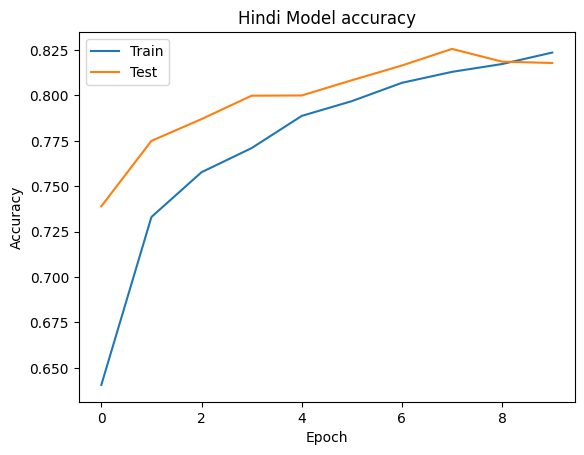

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hindi Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

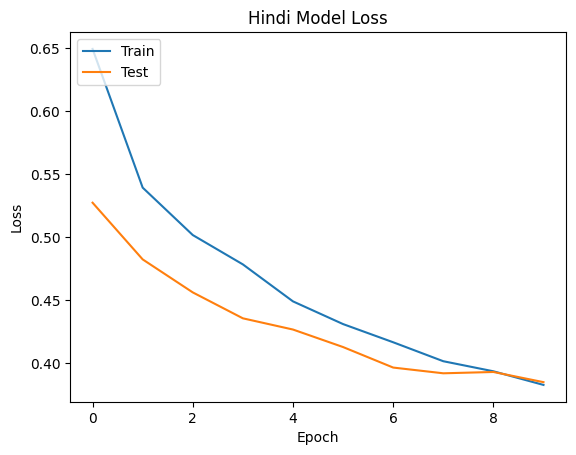

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hindi Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
def preprocess(data):
    
    # Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data.lower()

In [50]:
english_tokenizer = Tokenizer()

all_sentences_hi = X_train_eng + X_test_eng

english_tokenizer.fit_on_texts(X_english['text'].values)

# + 1 for unknown token
vocabSize = len(english_tokenizer.word_index) +1

X_train_eng_seq = english_tokenizer.texts_to_sequences(X_train_eng['text'])
X_test_eng_seq = english_tokenizer.texts_to_sequences(X_test_eng['text'])

# Initializing max length of sentence to 70 words
max_length = 70

In [53]:
# Padding sequences
padded_X_train_eng_sequences = pad_sequences(english_tokenizer.texts_to_sequences(X_train_eng['text']), maxlen=max_length, padding='post')
padded_X_test_eng_sequences = pad_sequences(english_tokenizer.texts_to_sequences(X_test_eng['text']), maxlen=max_length, padding='post')

In [59]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-01-23 09:29:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-23 09:29:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-23 09:29:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [63]:
# Read GloVE embeddings
path_to_glove_file = '../working/glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300 #latent factors or features  
hits = 0
misses = 0
embeddings_index_english = {}

In [64]:
# Load GloVe word embeddings from the specified file
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_english[word] = coefs
print("Found %s word vectors." % len(embeddings_index_english))


# Initialize an embedding matrix for our neural network
embedding_matrix_english = np.zeros((num_tokens, embedding_dim))

# Assign pre-trained word vectors to our vocabulary
for word, i in english_tokenizer.word_index.items():
    embedding_vector_english = embeddings_index_english.get(word)
    if embedding_vector_english is not None:
        # Words found in the embedding index are assigned their respective vectors
        embedding_matrix_english[i] = embedding_vector_english
        hits += 1
    else:
        # Words not found in the embedding index are set to all-zeros
        # This includes the representation for "padding" and "OOV" (Out of Vocabulary)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 70567 words (41627 misses)


In [70]:

# Initialize a Sequential model
model1 = Sequential()

# Embedding layer with pre-trained word vectors
model1.add(Embedding(input_dim=vocabSize, output_dim=300, input_length=max_length))

# Bidirectional LSTM layers with dropout and recurrent dropout
model1.add(Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=64, return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(units=16))

# # Batch Normalization layer
# model.add(BatchNormalization())

# Dense output layer with softmax activation
model1.add(Dense(units=3, activation='softmax'))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Optimizer with learning rate scheduling and gradient clipping
learning_rate_schedule = schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
adam_optimizer = Adam(learning_rate=learning_rate_schedule, clipvalue=1.0)
model1.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 70, 300)           33658500  
                                                                 
 bidirectional_8 (Bidirecti  (None, 70, 256)           439296    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 70, 256)           0         
                                                                 
 lstm_25 (LSTM)              (None, 70, 64)            82176     
                                                                 
 dropout_17 (Dropout)        (None, 70, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 16)                5184      
                                                      

In [71]:
# Model training
history1 = model1.fit(padded_X_train_eng_sequences, Y_train_eng, epochs=10, batch_size=256, validation_data=(padded_X_test_eng_sequences, Y_test_eng), shuffle=False, callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 84s 606ms/step - loss: 0.7213 - accuracy: 0.5020 - val_loss: 0.6985 - val_accuracy: 0.4996
Epoch 2/10
125/125 [==============================] - 61s 488ms/step - loss: 0.6961 - accuracy: 0.4990 - val_loss: 0.6950 - val_accuracy: 0.4996
Epoch 3/10
125/125 [==============================] - 61s 491ms/step - loss: 0.6943 - accuracy: 0.5040 - val_loss: 0.6936 - val_accuracy: 0.4996
Epoch 4/10
125/125 [==============================] - 61s 491ms/step - loss: 0.6379 - accuracy: 0.6199 - val_loss: 0.4942 - val_accuracy: 0.7698
Epoch 5/10
125/125 [==============================] - 61s 492ms/step - loss: 0.4321 - accuracy: 0.8038 - val_loss: 0.3815 - val_accuracy: 0.8280
Epoch 6/10
125/125 [==============================] - 61s 484ms/step - loss: 0.3455 - accuracy: 0.8557 - val_loss: 0.3794 - val_accuracy: 0.8420
Epoch 7/10
125/125 [==============================] - 61s 486ms/step - loss: 0.3016 - accuracy: 0.8789 - val_loss: 0.4143 - val_ac

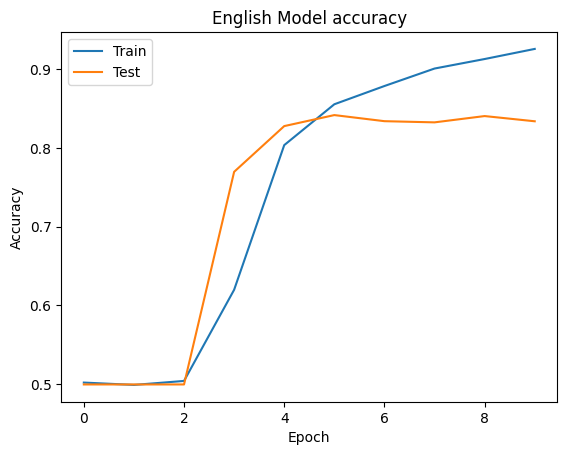

In [72]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('English Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()